<a href="https://colab.research.google.com/github/milicak/Data_Analysis_Course/blob/main/CA_fires_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install jdcal
!pip install cdsapi
import datetime
from jdcal import jd2gcal
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
import xarray as xr

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rtatman/188-million-us-wildfires")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/188-million-us-wildfires


In [3]:
##### 1. Loading raw data #####
input_filename = '/root/.cache/kagglehub/datasets/rtatman/188-million-us-wildfires/versions/2/FPA_FOD_20170508.sqlite'
input_filename = '/kaggle/input/188-million-us-wildfires/FPA_FOD_20170508.sqlite'
conn = sqlite3.connect(input_filename)
query = '''
    SELECT
        NWCG_REPORTING_AGENCY, NWCG_REPORTING_UNIT_ID,
        NWCG_REPORTING_UNIT_NAME,
        FIRE_NAME,
        COMPLEX_NAME,
        FIRE_YEAR,
        DISCOVERY_DATE,
        DISCOVERY_DOY,
        DISCOVERY_TIME,
        STAT_CAUSE_CODE,
        STAT_CAUSE_DESCR,
        CONT_DATE,
        CONT_DOY,
        CONT_TIME,
        FIRE_SIZE,
        FIRE_SIZE_CLASS,
        LATITUDE,
        LONGITUDE,
        OWNER_CODE,
        OWNER_DESCR,
        STATE,
        COUNTY
    FROM
        Fires;
'''
df_raw = pd.read_sql_query(query, conn)
df_raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880465 entries, 0 to 1880464
Data columns (total 22 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   NWCG_REPORTING_AGENCY     object 
 1   NWCG_REPORTING_UNIT_ID    object 
 2   NWCG_REPORTING_UNIT_NAME  object 
 3   FIRE_NAME                 object 
 4   COMPLEX_NAME              object 
 5   FIRE_YEAR                 int64  
 6   DISCOVERY_DATE            float64
 7   DISCOVERY_DOY             int64  
 8   DISCOVERY_TIME            object 
 9   STAT_CAUSE_CODE           float64
 10  STAT_CAUSE_DESCR          object 
 11  CONT_DATE                 float64
 12  CONT_DOY                  float64
 13  CONT_TIME                 object 
 14  FIRE_SIZE                 float64
 15  FIRE_SIZE_CLASS           object 
 16  LATITUDE                  float64
 17  LONGITUDE                 float64
 18  OWNER_CODE                float64
 19  OWNER_DESCR               object 
 20  STATE                   

In [4]:
##### 2. Cleaning data and extracting California #####
drop_columns = ['NWCG_REPORTING_AGENCY',
                'NWCG_REPORTING_UNIT_ID',
                'NWCG_REPORTING_UNIT_NAME',
                'FIRE_NAME',
                'COMPLEX_NAME',
                'OWNER_DESCR',
                'FIRE_SIZE_CLASS',
                'OWNER_CODE']
df_CA = df_raw[df_raw.STATE == 'CA'].drop(columns=drop_columns)
#Extracting onset month and day
df_CA['MONTH'] = df_CA['DISCOVERY_DATE'].apply(lambda x: jd2gcal(x, 0)[1])
df_CA['DAY'] = df_CA['DISCOVERY_DATE'].apply(lambda x: jd2gcal(x, 0)[2])

In [ ]:
df_CA

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,LATITUDE,LONGITUDE,STATE,COUNTY,MONTH,DAY
0,2005,2453403.5,33,1300,9.0,Miscellaneous,2453403.5,33.0,1730,0.10,40.036944,-121.005833,CA,63,2,2
1,2004,2453137.5,133,0845,1.0,Lightning,2453137.5,133.0,1530,0.25,38.933056,-120.404444,CA,61,5,12
2,2004,2453156.5,152,1921,5.0,Debris Burning,2453156.5,152.0,2024,0.10,38.984167,-120.735556,CA,17,5,31
3,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1400,0.10,38.559167,-119.913333,CA,3,6,28
4,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1200,0.10,38.559167,-119.933056,CA,3,6,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880460,2015,2457291.5,269,1726,13.0,Missing/Undefined,2457291.5,269.0,1843,0.01,40.481637,-122.389375,CA,None,9,26
1880461,2015,2457300.5,278,0126,9.0,Miscellaneous,NaN,NaN,None,0.20,37.617619,-120.938570,CA,None,10,5
1880462,2015,2457144.5,122,2052,13.0,Missing/Undefined,NaN,NaN,None,0.10,37.617619,-120.938570,CA,None,5,2
1880463,2015,2457309.5,287,2309,13.0,Missing/Undefined,NaN,NaN,None,2.00,37.672235,-120.898356,CA,None,10,14


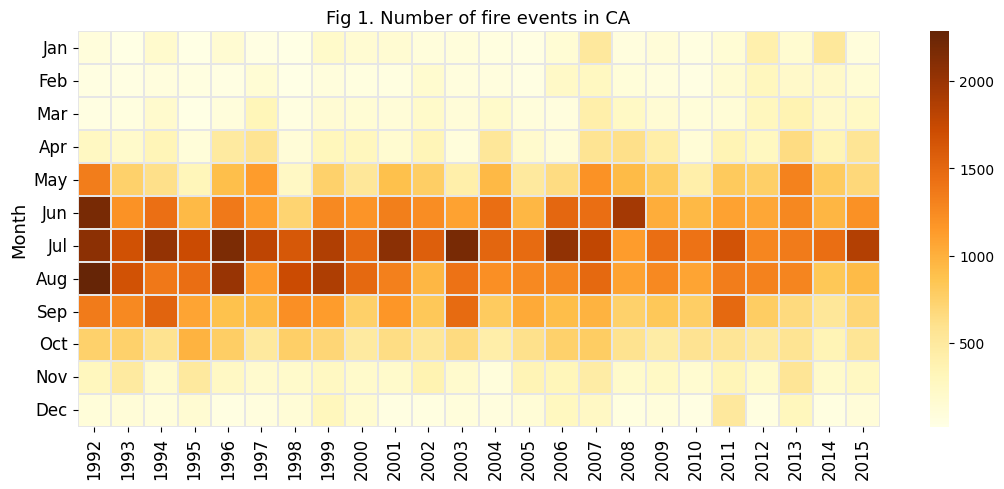

In [5]:
##### 3. Monthly/seasonal fire frequency #####
df_freq_mon = df_CA.groupby(['MONTH', 'FIRE_YEAR']).size().unstack()
# plot monthly frequency of fire events
counter_fig = 1
mon_ticks = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.figure(figsize=[11,5])
sns.heatmap(df_freq_mon, cmap='YlOrBr', linewidth=.2, linecolor=[.9,.9,.9])
plt.yticks(np.arange(0.5,12.5), labels=mon_ticks, rotation=0, fontsize=12)
plt.xticks(fontsize=12);
plt.xlabel('')
plt.ylabel('Month', fontsize=13)
plt.title(f'Fig {counter_fig}. Number of fire events in CA', fontsize=13)
plt.tight_layout()

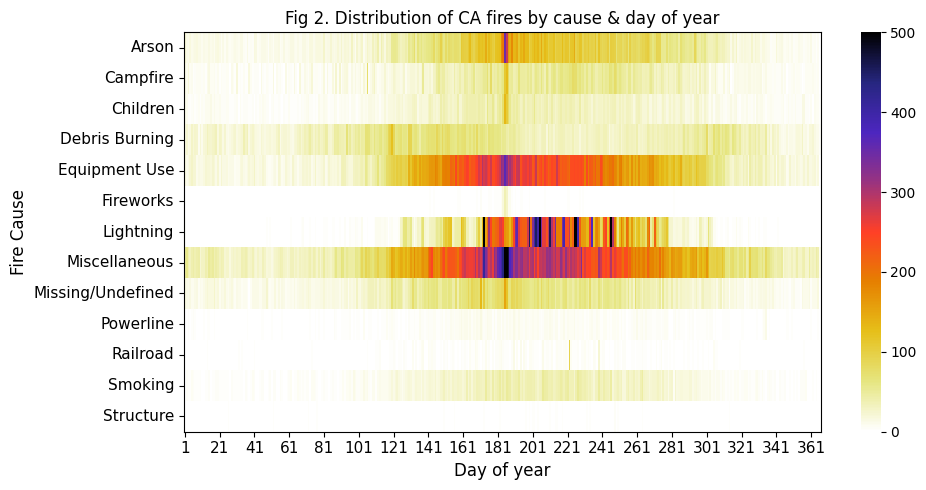

In [6]:
# plot fire frequency by cause and day of year
cause_by_doy = df_CA.groupby(['STAT_CAUSE_DESCR','DISCOVERY_DOY']).size().unstack()
counter_fig +=1
plt.figure(figsize=[10,5])
ax = sns.heatmap(cause_by_doy,cmap='CMRmap_r',vmin=0,vmax=500)
plt.xticks(np.arange(0.5,366.5,20), labels=range(1,366,20), rotation=0, fontsize=11)
plt.yticks(fontsize=11)
plt.ylabel('Fire Cause', fontsize=12)
plt.xlabel('Day of year', fontsize=12)
for borders in ["top","right","left","bottom"]:
    ax.spines[borders].set_visible(True)
plt.title(f'Fig {counter_fig}. Distribution of CA fires by cause & day of year')
plt.tight_layout()

In [7]:
apikey = '052d98c0-2b93-40f0-b62c-2cbf49161d5d'

In [ ]:
!pip install xarray[complete]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.4/205.4 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 3.8 MB/s eta 0:00:00


In [8]:
!rm ERA5_monthly.nc
##### 4. Download and extract climate data (ERA5) #####
import cdsapi
def _download_era5(variables :list, filename: str):
    c = cdsapi.Client(key=f"{apikey}", url="https://cds.climate.copernicus.eu/api/")
    c.retrieve('reanalysis-era5-single-levels-monthly-means',
               {'format': 'netcdf',
                'product_type': 'monthly_averaged_reanalysis',
                'variable': variables,
                'year': [f'{yr}' for yr in range(1992,2016)],
                'month': [f'{x:02.0f}' for x in range(1,13)],
                'time': '00:00',
                'area': [42, -124, 32.5,-115],
               },
               f'{filename}.nc')

#vars_all = ['total_precipitation', '2m_temperature', '2m_dewpoint_temperature',
#           '10m_wind_speed', 'volumetric_soil_water_layer_1','potential_evaporation']
vars_all = ['2m_temperature']
c = cdsapi.Client(key=f"{apikey}", url="https://cds.climate.copernicus.eu/api/")
_download_era5(vars_all, 'ERA5_monthly')
ds_era5 = xr.open_dataset('ERA5_monthly.nc')

rm: cannot remove 'ERA5_monthly.nc': No such file or directory


2025-05-22 06:38:31,986 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-05-22 06:38:31,988 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-05-22 06:38:32,401 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-05-22 06:38:32,403 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or p

d756b193c0f8cc32a4442da1114d0e0e.nc:   0%|          | 0.00/731k [00:00<?, ?B/s]

In [9]:
ds_era5

<xarray.Dataset> Size: 2MB
Dimensions:     (valid_time: 288, latitude: 39, longitude: 37)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 2kB 1992-01-01 ... 2015-12-01
  * latitude    (latitude) float64 312B 42.0 41.75 41.5 ... 33.0 32.75 32.5
  * longitude   (longitude) float64 296B -124.0 -123.8 -123.5 ... -115.2 -115.0
    expver      (valid_time) <U4 5kB ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 2MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

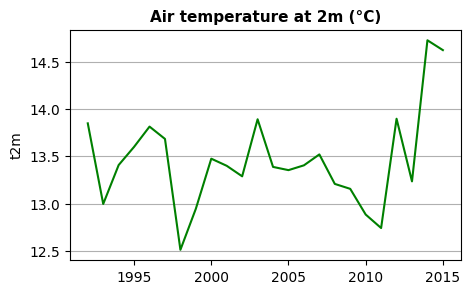

In [10]:
##### 5. Assessing climate trends #####
# plot climate trends
counter_fig +=1
var = list(ds_era5.data_vars)
titles = {"t2m":"Air temperature at 2m (°C)"}
unit_conversion = {"t2m": [1,-273.15]}
fig = plt.figure(figsize=(13, 5.5))
gs = gridspec.GridSpec(2, 3)
for i in range(len(var)):
    plt.subplot(gs[i])
    #(ds_era5[var[i]].where(CA_mask).mean(['latitude','longitude']).groupby(
    (ds_era5[var[i]].mean(['latitude','longitude']).groupby(
        ds_era5.valid_time.dt.year).mean()*unit_conversion[var[i]][0] + \
        unit_conversion[var[i]][1]).plot(color='g')
    plt.xlabel('')
    plt.grid(axis='y')
    plt.title(titles[var[i]], fontsize=11, fontweight='bold')
plt.tight_layout()

In [11]:
##### 6. Assessing the climate factors affecting fires #####
df_freq = pd.DataFrame(df_CA.groupby(['FIRE_YEAR','MONTH']).size(), columns=['Frequency'])
df_freq = df_freq.reset_index().rename(columns={'FIRE_YEAR':'Year', 'MONTH':'Month'})
# extract monthly ERA5 data
def extract_era5_yr_mon(yr, mon, var):
    unit_conversion = {"t2m": [1,-273.15]}
    ds_yr_mon = ds_era5.sel(valid_time = ds_era5.valid_time.dt.month.isin(mon) & ds_era5.valid_time.dt.year.isin(yr))
    output = float(ds_yr_mon[var].mean(['latitude','longitude']).values) * \
    unit_conversion[var][0] + unit_conversion[var][1]
    return output


<ipython-input-11-50d09ba662cd>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output = float(ds_yr_mon[var].mean(['latitude','longitude']).values) * \
<ipython-input-11-50d09ba662cd>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output = float(ds_yr_mon[var].mean(['latitude','longitude']).values) * \
<ipython-input-11-50d09ba662cd>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output = float(ds_yr_mon[var].mean(['latitude','longitude']).values) * \
<ipytho

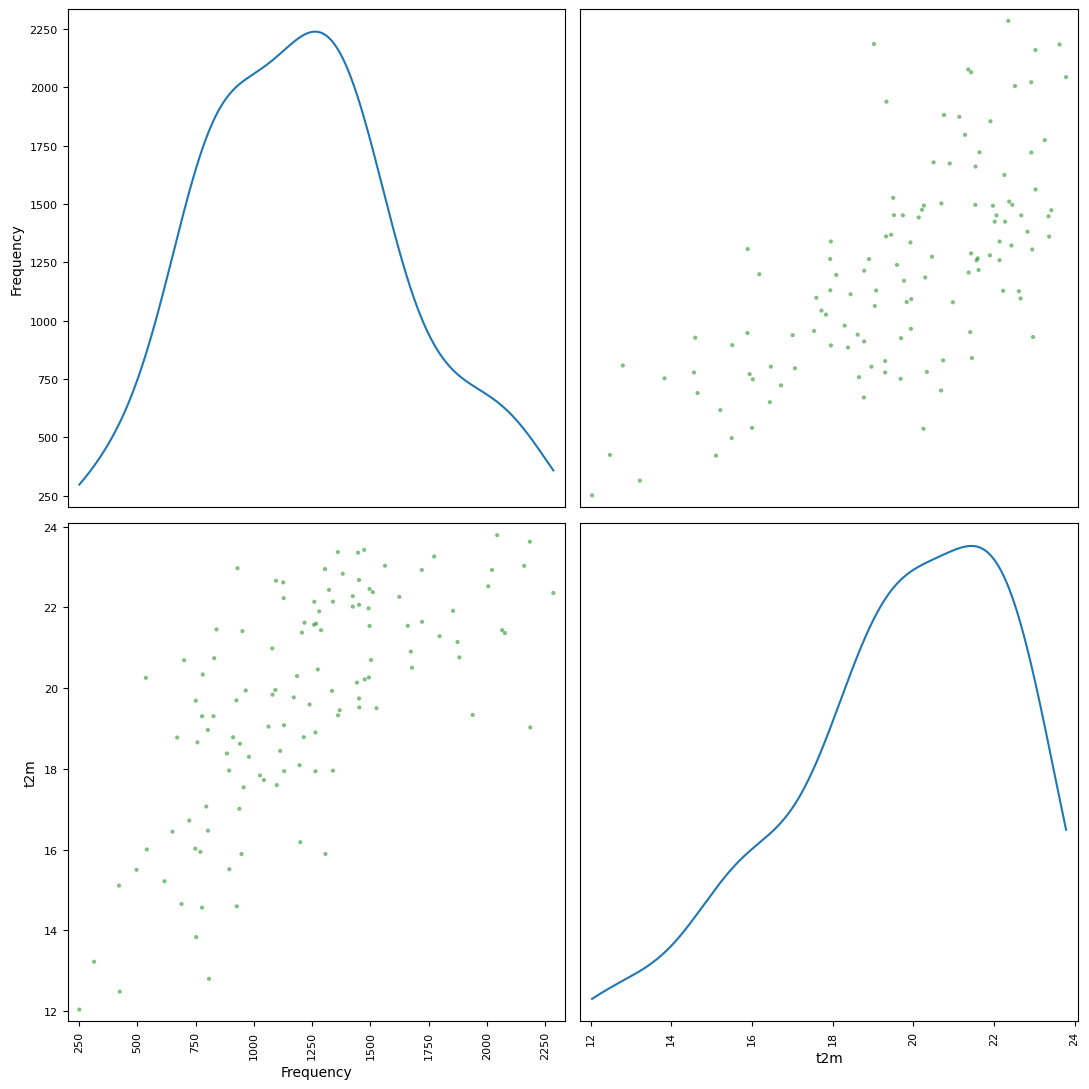

In [12]:
# adding climate data to the dataframe
for i in range(len(var)):
    df_freq[var[i]] = df_freq.apply(lambda x: extract_era5_yr_mon(x.Year, x.Month, var[i]), axis=1)

# plotting scatter matrix for summer (MJJAS)
#plt.style.use('seaborn')
counter_fig +=1
df_freq_summer = df_freq[df_freq.Month.isin([5,6,7,8,9])]
pd.plotting.scatter_matrix(df_freq_summer.drop(
    columns=['Year','Month']), alpha=0.5, color='g', figsize=(11, 11), diagonal='kde',);
plt.tight_layout()


In [13]:
##### 7. Setup the ANN model #####
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

In [14]:
def ANN_fit(X,y):
    # temporal split into train and test
    ind_split = int(len(y)*.7)
    X_train = X[:ind_split];    X_test = X[ind_split:]
    y_train = y[:ind_split];    y_test = y[ind_split:]

    # scaling data
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # setting up and fitting the model
    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
    model = Sequential()
    model.add(Dense(16,activation='relu'))
    model.add(Dense(16,activation='relu'))
    model.add(Dense(8,activation='relu'))
    #model.add(Dense(4,activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, y_train, epochs=3500, validation_data=(X_test, y_test),
                        verbose=0, shuffle=False, callbacks=[early_stop])

    # plotting the loss function
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

    # predicting the test period
    test_predictions = model.predict(X_test)
    test_predictions = pd.Series(test_predictions.reshape(test_predictions.shape[0], ))
    pred_df = pd.DataFrame(y_test, columns=['Test True Y'])
    pred_df = pd.concat([pred_df, test_predictions], axis=1)
    pred_df.columns = ['Test True Y', 'Model Prediction']
    pred_df['Year'] = df_freq[ind_split:].Year.values
    pred_df['Month'] = df_freq[ind_split:].Month.values

    return pred_df


In [40]:
def ANN_fit_single(X,y):
    # temporal split into train and test
    ind_split = int(len(y)*.7)
    X_train = X[:ind_split];    X_test = X[ind_split:]
    y_train = y[:ind_split];    y_test = y[ind_split:]

    # scaling data
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # setting up and fitting the model
    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
    model = Sequential()
    model.add(Dense(16,activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, y_train, epochs=3500, validation_data=(X_test, y_test),
                        verbose=0, shuffle=False, callbacks=[early_stop])

    # plotting the loss function
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

    # predicting the test period
    test_predictions = model.predict(X_test)
    test_predictions = pd.Series(test_predictions.reshape(test_predictions.shape[0], ))
    pred_df = pd.DataFrame(y_test, columns=['Test True Y'])
    pred_df = pd.concat([pred_df, test_predictions], axis=1)
    pred_df.columns = ['Test True Y', 'Model Prediction']
    pred_df['Year'] = df_freq[ind_split:].Year.values
    pred_df['Month'] = df_freq[ind_split:].Month.values

    return pred_df

In [15]:
##################################################
##### 8. Fitting the ANN model #####
plt.style.use('ggplot')
y = df_freq['Frequency'].values
X = df_freq.drop(columns=['Frequency']).values


Epoch 804: early stopping


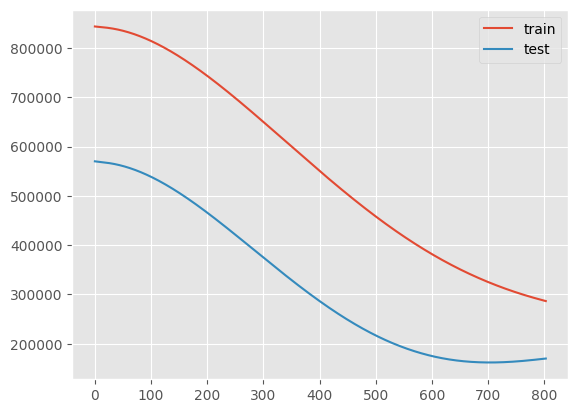

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [41]:
pred_df_single = ANN_fit_single(X, y)

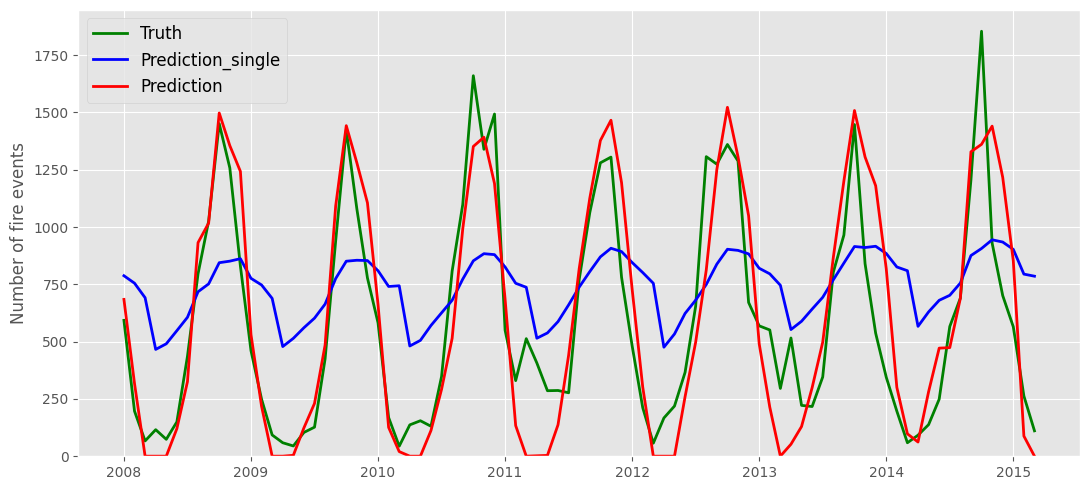

In [42]:
counter_fig +=1
plt.figure(figsize=[11,5])
plt.plot(pred_df['Test True Y'], color='g', linewidth=2, label='Truth')
plt.plot(pred_df_single['Model Prediction'], color='b', linewidth=2, label='Prediction_single')
plt.plot(pred_df['Model Prediction'], color='r', linewidth=2, label='Prediction')
plt.xticks(ticks=range(0,len(pred_df),12), labels=pred_df.Year[::12])
plt.ylim(bottom=0)
plt.ylabel('Number of fire events', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()

In [33]:
df_freq

,Year,Month,Frequency,t2m
0,1992,1,92,5.015741
1,1992,2,54,8.599512
2,1992,3,48,9.920374
3,1992,4,259,14.226617
4,1992,5,1339,17.957300
...,...,...,...,...
283,2015,8,930,22.971490
284,2015,9,701,20.690729
285,2015,10,565,16.858392
286,2015,11,263,7.741846


In [ ]:
X

array([[1.99200000e+03, 1.00000000e+00, 5.01574097e+00],
       [1.99200000e+03, 2.00000000e+00, 8.59951172e+00],
       [1.99200000e+03, 3.00000000e+00, 9.92040405e+00],
       [1.99200000e+03, 4.00000000e+00, 1.42266174e+01],
       [1.99200000e+03, 5.00000000e+00, 1.79572693e+01],
       [1.99200000e+03, 6.00000000e+00, 1.90263916e+01],
       [1.99200000e+03, 7.00000000e+00, 2.14373718e+01],
       [1.99200000e+03, 8.00000000e+00, 2.23582703e+01],
       [1.99200000e+03, 9.00000000e+00, 1.93265625e+01],
       [1.99200000e+03, 1.00000000e+01, 1.56785522e+01],
       [1.99200000e+03, 1.10000000e+01, 8.75426636e+00],
       [1.99200000e+03, 1.20000000e+01, 3.92061768e+00],
       [1.99300000e+03, 1.00000000e+00, 4.00164185e+00],
       [1.99300000e+03, 2.00000000e+00, 5.63305054e+00],
       [1.99300000e+03, 3.00000000e+00, 1.02574707e+01],
       [1.99300000e+03, 4.00000000e+00, 1.19526001e+01],
       [1.99300000e+03, 5.00000000e+00, 1.60227600e+01],
       [1.99300000e+03, 6.00000

Epoch 437: early stopping


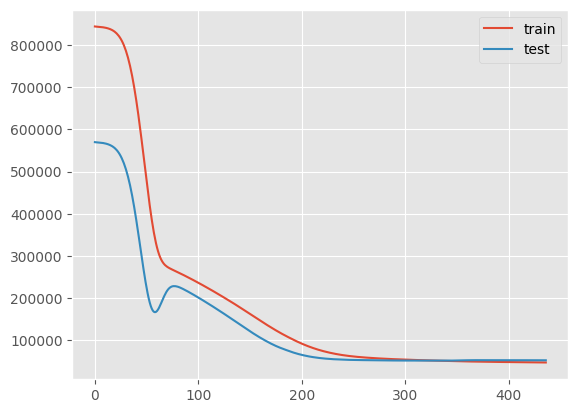

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [38]:
pred_df = ANN_fit(X, y)

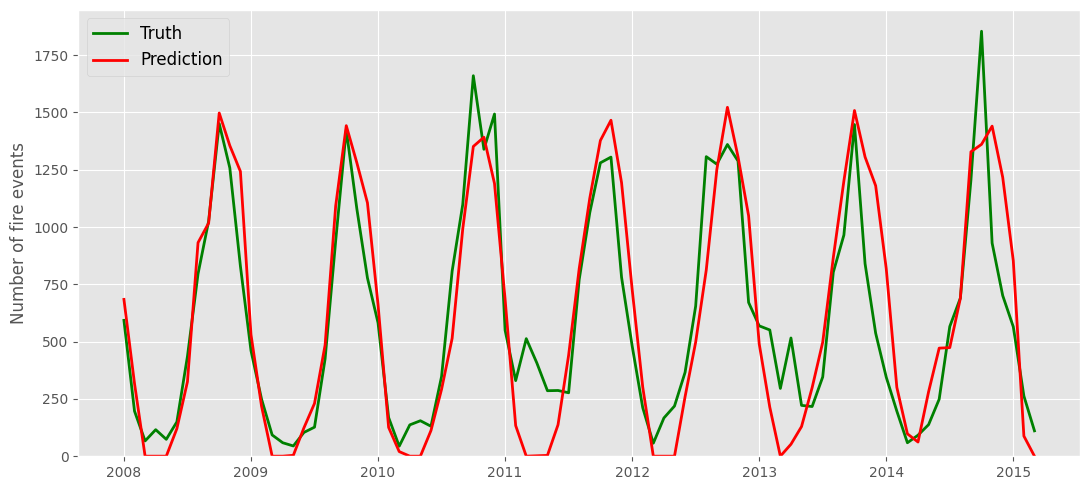

In [39]:
# plotting the prediction vs. observation
counter_fig +=1
plt.figure(figsize=[11,5])
plt.plot(pred_df['Test True Y'], color='g', linewidth=2, label='Truth')
plt.plot(pred_df['Model Prediction'], color='r', linewidth=2, label='Prediction')
plt.xticks(ticks=range(0,len(pred_df),12), labels=pred_df.Year[::12])
plt.ylim(bottom=0)
plt.ylabel('Number of fire events', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()

In [54]:
!rm ERA5_monthly_Pacicfic.nc
##### 4. Download and extract climate data (ERA5) #####
import cdsapi
def _download_era5(variables :list, filename: str):
    c = cdsapi.Client(key=f"{apikey}", url="https://cds.climate.copernicus.eu/api/")
    c.retrieve('reanalysis-era5-single-levels-monthly-means',
               {'format': 'netcdf',
                'product_type': 'monthly_averaged_reanalysis',
                'variable': variables,
                'year': [f'{yr}' for yr in range(1950,2016)],
                'month': [f'{x:02.0f}' for x in range(1,13)],
                'time': '00:00',
                'area': [40, 120, -10,-80],
               },
               f'{filename}.nc')

#vars_all = ['total_precipitation', '2m_temperature', '2m_dewpoint_temperature',
#           '10m_wind_speed', 'volumetric_soil_water_layer_1','potential_evaporation']
vars_all = ['2m_temperature']
c = cdsapi.Client(key=f"{apikey}", url="https://cds.climate.copernicus.eu/api/")
_download_era5(vars_all, 'ERA5_monthly_Pacicfic')
ds_era5_pacific = xr.open_dataset('ERA5_monthly_Pacicfic.nc')

2025-05-22 08:03:34,965 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-05-22 08:03:34,967 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-05-22 08:03:35,487 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-05-22 08:03:35,488 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or p

3d91d6e521165fff35d6262dcfe196ef.nc:   0%|          | 0.00/123M [00:00<?, ?B/s]

In [55]:
ds_era5_pacific

<xarray.Dataset> Size: 408MB
Dimensions:     (valid_time: 792, latitude: 201, longitude: 641)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 6kB 1950-01-01 ... 2015-12-01
  * latitude    (latitude) float64 2kB 40.0 39.75 39.5 ... -9.5 -9.75 -10.0
  * longitude   (longitude) float64 5kB 120.0 120.2 120.5 ... 279.5 279.8 280.0
    expver      (valid_time) <U4 13kB ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 408MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

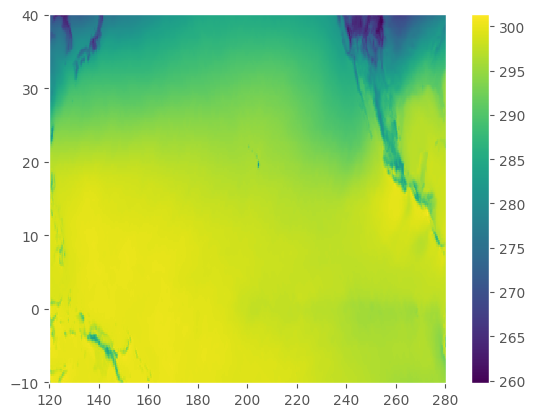

In [56]:
plt.pcolormesh(ds_era5_pacific.longitude,ds_era5_pacific.latitude,ds_era5_pacific.t2m[0,:,:]);plt.colorbar()

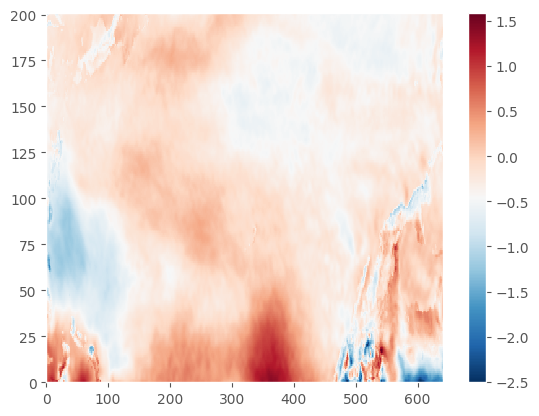

In [57]:
ds_season = ds_era5_pacific.where(ds_era5_pacific['valid_time.season'] == 'DJF').groupby('valid_time.year').mean('valid_time')
sst = ds_season - ds_season.t2m.mean('year')
plt.pcolormesh(sst.t2m[12,:,:],cmap='RdBu_r');plt.colorbar()

In [58]:
!pip install eofs
!pip install cartopy
from eofs.xarray import Eof
# convert to data_array
sst = sst.t2m
# rename time variable to be consistent with the EOFS package
sst = sst.rename({'year':'time'})
coslat = np.cos(np.deg2rad(sst.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(-sst, weights=wgts)
# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input SST anomalies at each grid point, and the
# leading PC time series itself.
eof1 = solver.eofsAsCorrelation(neofs=1)
pc1 = solver.pcs(npcs=1, pcscaling=1)

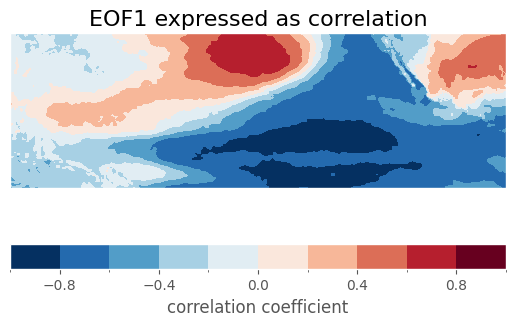

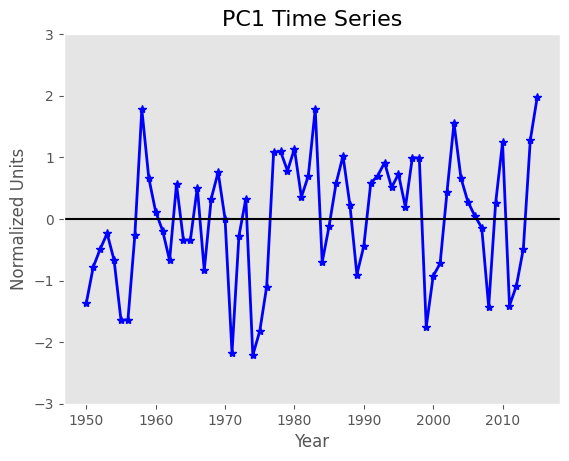

In [59]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# Plot the leading EOF expressed as correlation in the Pacific domain.
clevs = np.linspace(-1, 1, 11)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = eof1[0].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='w', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EOF1 expressed as correlation', fontsize=16)

# Plot the leading PC time series.
plt.figure()
pc1[:, 0].plot(color='b',marker='*', linewidth=2)
plt.grid()
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC1 Time Series', fontsize=16)

plt.show()

In [60]:
pc1[:, 0]

<xarray.DataArray 'pcs' (time: 66)> Size: 264B
array([-1.3642086e+00, -7.7947778e-01, -4.8930296e-01, -2.3538519e-01,
       -6.6954535e-01, -1.6459064e+00, -1.6366203e+00, -2.5724721e-01,
        1.7826501e+00,  6.6669172e-01,  1.1542676e-01, -1.9125935e-01,
       -6.7135066e-01,  5.6300300e-01, -3.4427214e-01, -3.4176055e-01,
        5.0990713e-01, -8.3686519e-01,  3.2583496e-01,  7.5901693e-01,
       -7.2220451e-04, -2.1750715e+00, -2.7590910e-01,  3.2885396e-01,
       -2.2116971e+00, -1.8223447e+00, -1.0983639e+00,  1.0828646e+00,
        1.0956687e+00,  7.8071105e-01,  1.1380030e+00,  3.5428071e-01,
        6.9817930e-01,  1.7828418e+00, -7.0306748e-01, -1.1538310e-01,
        5.7506806e-01,  1.0227071e+00,  2.2496025e-01, -9.0254956e-01,
       -4.4153509e-01,  5.7923245e-01,  7.0082909e-01,  9.1546315e-01,
        5.1160425e-01,  7.2623485e-01,  1.9185150e-01,  9.9579698e-01,
        9.8461813e-01, -1.7539115e+00, -9.2726058e-01, -7.2318822e-01,
        4.4364142e-01,  1.5567454e+00,  6.6606659e-01,  2.7930105e-01,
        5.1440150e-02, -1.4272377e-01, -1.4296080e+00,  2.5405863e-01,
        1.2411314e+00, -1.4078764e+00, -1.0853869e+00, -4.8253700e-01,
        1.2786068e+00,  1.9790466e+00], dtype=float32)
Coordinates:
  * time     (time) int64 528B 1950 1951 1952 1953 1954 ... 2012 2013 2014 2015
    mode     int64 8B 0

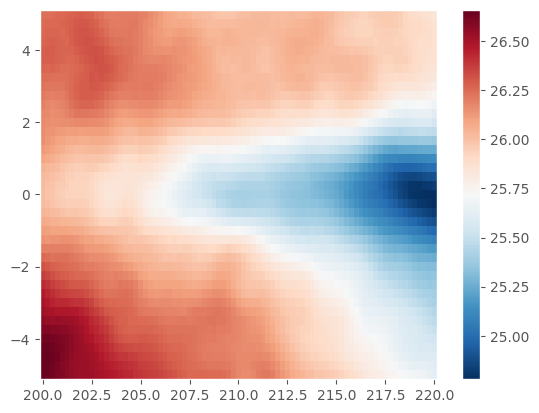

In [79]:
ds_era5_eq = ds_era5_pacific.sel(longitude=slice(200,220),latitude=slice(5,-5))
ds_season_summer = ds_era5_eq.where(ds_era5_eq['valid_time.season'] == 'JJA').groupby('valid_time.year').mean('valid_time')
ds_season_summer
sst_summer = ds_season_summer -273.15 #- ds_season_summer.t2m.mean('year')
plt.pcolormesh(sst_summer.longitude,sst_summer.latitude,sst_summer.t2m[12,:,:],cmap='RdBu_r');plt.colorbar()

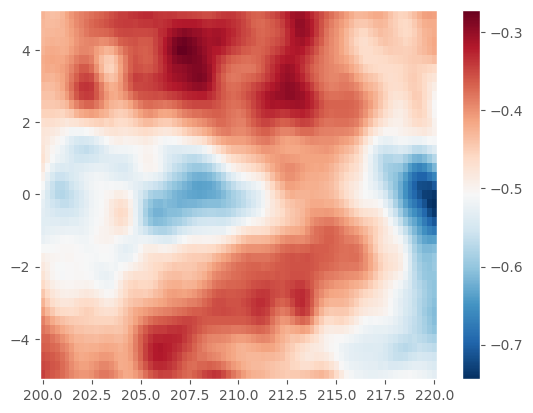

In [62]:
ds_era5_eq = ds_era5_pacific.sel(longitude=slice(200,220),latitude=slice(5,-5))
ds_season_autumun = ds_era5_eq.where(ds_era5_eq['valid_time.season'] == 'SON').groupby('valid_time.year').mean('valid_time')
ds_season_autumun
sst_autumn = ds_season_autumun - ds_season_autumun.t2m.mean('year')
plt.pcolormesh(sst_summer.longitude,sst_summer.latitude,sst_autumn.t2m[12,:,:],cmap='RdBu_r');plt.colorbar()

In [80]:
sst_summer_mean = sst_summer.mean(('longitude','latitude'))
sst_autumn_mean = sst_autumn.mean(('longitude','latitude'))

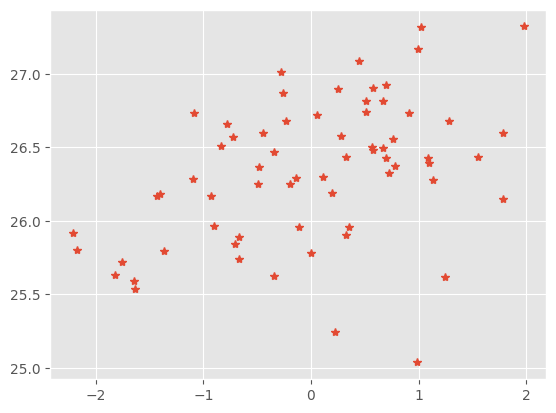

In [81]:
plt.plot(pc1[:, 0],sst_summer_mean.t2m,'*')

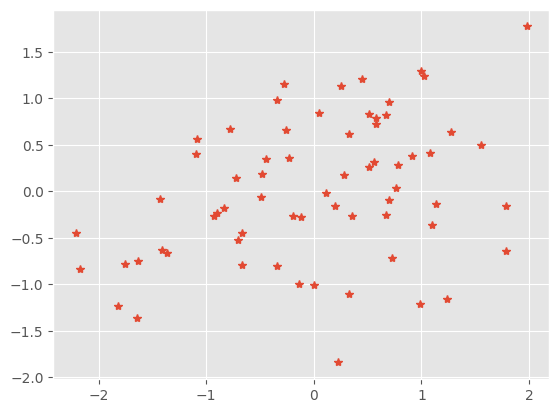

In [65]:
plt.plot(pc1[:, 0],sst_autumn_mean.t2m,'*')

In [82]:
X2=np.array([np.copy(sst_summer_mean.year[:]),np.copy(sst_summer_mean.t2m[:])])
np.transpose(X2)

array([[1950.        ,   25.79728889],
       [1951.        ,   26.65550041],
       [1952.        ,   26.24843407],
       [1953.        ,   26.67988586],
       [1954.        ,   25.73817825],
       [1955.        ,   25.58830643],
       [1956.        ,   25.53835487],
       [1957.        ,   26.8693676 ],
       [1958.        ,   26.59733963],
       [1959.        ,   26.49463844],
       [1960.        ,   26.29980659],
       [1961.        ,   26.25112915],
       [1962.        ,   25.89182854],
       [1963.        ,   26.50290298],
       [1964.        ,   25.62675285],
       [1965.        ,   26.46533966],
       [1966.        ,   26.81348991],
       [1967.        ,   26.50566864],
       [1968.        ,   26.43469048],
       [1969.        ,   26.55781555],
       [1970.        ,   25.77804565],
       [1971.        ,   25.80068207],
       [1972.        ,   27.010746  ],
       [1973.        ,   25.90270233],
       [1974.        ,   25.91531181],
       [1975.        ,   

In [94]:
def ANN_fit2(X,y):
    # temporal split into train and test
    ind_split = int(len(y)*.7)
    X_train = X[:ind_split];    X_test = X[ind_split:]
    y_train = y[:ind_split];    y_test = y[ind_split:]

    # scaling data
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # setting up and fitting the model
    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
    model = Sequential()
    model.add(Dense(16,activation='relu'))
    model.add(Dense(16,activation='relu'))
    model.add(Dense(8,activation='relu'))
    #model.add(Dense(4,activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, y_train, epochs=3500, validation_data=(X_test, y_test),
                        verbose=0, shuffle=False, callbacks=[early_stop])

    # plotting the loss function
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

    # predicting the test period
    test_predictions = model.predict(X_test)
    test_predictions = pd.Series(test_predictions.reshape(test_predictions.shape[0], ))
    pred_df = pd.DataFrame(y_test, columns=['Test True Y'])
    pred_df = pd.concat([pred_df, test_predictions], axis=1)
    pred_df.columns = ['Test True Y', 'Model Prediction']
    #pred_df['Year'] = df_freq[ind_split:].Year.values
    #pred_df['Month'] = df_freq[ind_split:].Month.values

    return pred_df

In [95]:
X2[:,30]

array([1980.        ,   26.27971649])

Epoch 116: early stopping


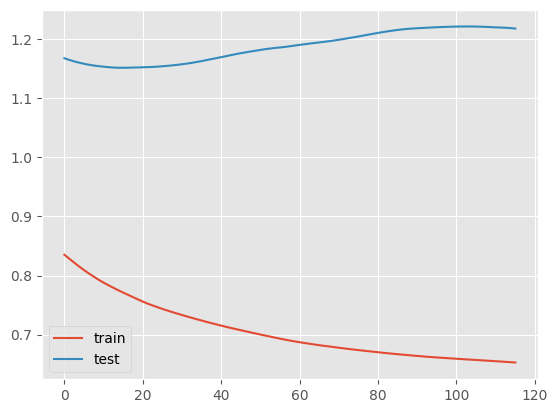

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


In [96]:
pred_df = ANN_fit2(np.transpose(X2[:,30:]), np.copy(pc1[30:, 0]))

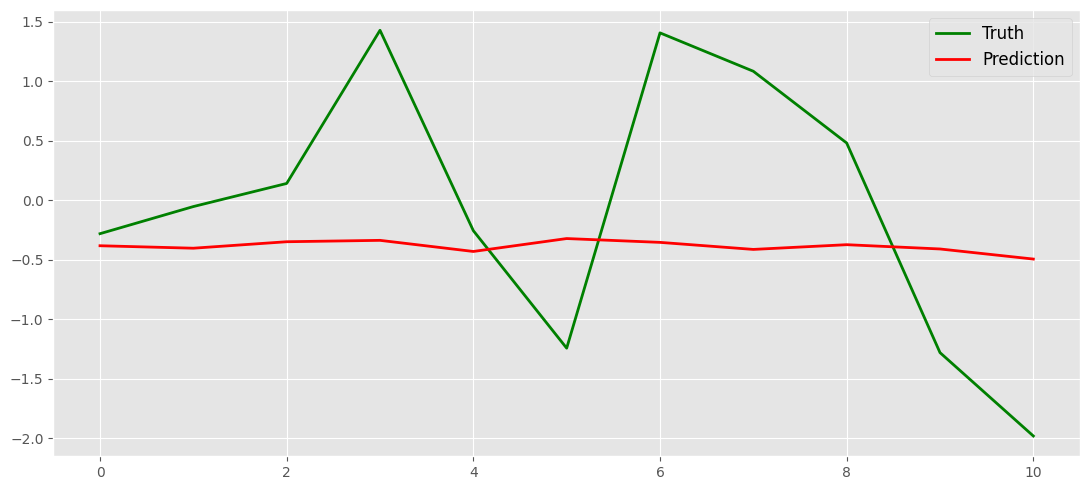

In [97]:
# plotting the prediction vs. observation
counter_fig +=1
plt.figure(figsize=[11,5])
plt.plot(-pred_df['Test True Y'], color='g', linewidth=2, label='Truth')
plt.plot(-pred_df['Model Prediction'], color='r', linewidth=2, label='Prediction')
#plt.xticks(ticks=range(0,len(pred_df),12), labels=pred_df.Year[::12])
#plt.ylim(bottom=0)
#plt.ylabel('Number of fire events', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()

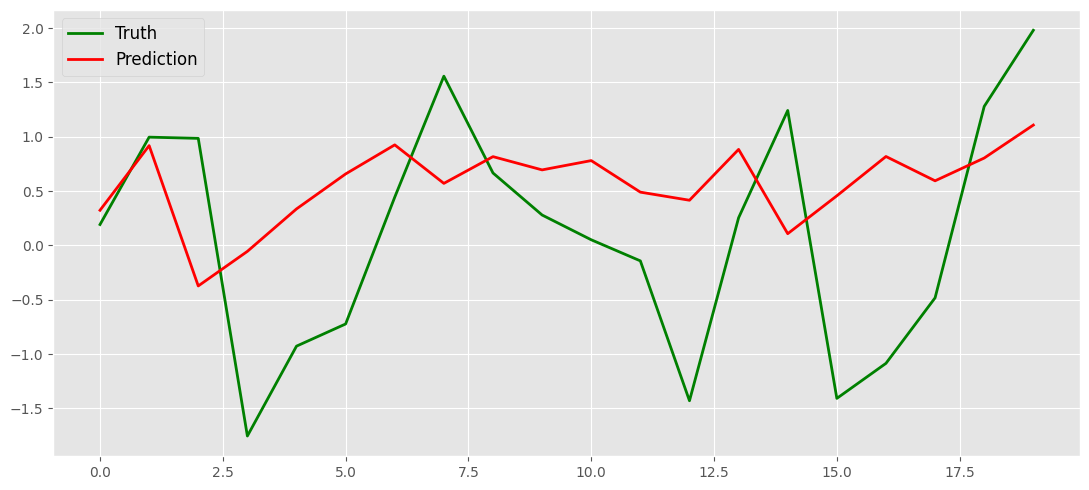

In [71]:
# plotting the prediction vs. observation
counter_fig +=1
plt.figure(figsize=[11,5])
plt.plot(pred_df['Test True Y'], color='g', linewidth=2, label='Truth')
plt.plot(pred_df['Model Prediction'], color='r', linewidth=2, label='Prediction')
#plt.xticks(ticks=range(0,len(pred_df),12), labels=pred_df.Year[::12])
#plt.ylim(bottom=0)
#plt.ylabel('Number of fire events', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()